# The Generalized Logistic Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
import pandas as pd
import patsy as pt

from yeastdnnexplorer.utils.sigmoid import sigmoid
from yeastdnnexplorer.ml_models.GeneralizedLogisticModel import GeneralizedLogisticModel

## The Sigmoid Function

The `sigmoid()` function takes the following arguments:

- The observations as a model matrix, where the first column is a constant vector
- Upper Asymptote: The upper bound of the sigmoid curve.
- Lower Asymptote: The lower bound of the sigmoid curve.
- Coefficients (B): The coefficients of the linear combination of input variables
that will control the shape of the sigmoid curve.

$$
Y(X) = \frac{right\_asymptote - left\_asymptote}{1 + e^{- X \cdot B }} + left\_asymptote
$$


In [ ]:
# Interactive function to update the plot
def update_plot(left_asymptote, right_asymptote, coef_0, coef_1):
    X1 = np.linspace(-10, 20, 100)
    X0 = np.ones_like(X1)
    X = np.column_stack([X0, X1])  # Adding intercept column
    
    B = [coef_0, coef_1]  # Coefficients for intercept and X1
    
    # Calculate Y using the simplified logistic function
    y = sigmoid(
        X,
        left_asymptote,
        right_asymptote,
        B)
    
    # Plot with larger figure size
    plt.figure(figsize=(7, 5))
    plt.plot(X1, y, label="Generalized Logistic Curve (Simplified)", color="b")
    plt.ylim(left_asymptote - 1, right_asymptote + 1)  # Adjust Y limits to match asymptotes
    plt.xlim(-10, 20)  # Adjust Y limits to match asymptotes
    plt.title("2D Sigmoid Curve")
    plt.xlabel("X1")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for each parameter
interact(
    update_plot,
    left_asymptote=widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description="Lower Asymptote"),
    right_asymptote=widgets.FloatSlider(min=0, max=10, step=0.1, value=1, description="Upper Asymptote"),
    coef_0=widgets.FloatSlider(min=-10, max=10, step=0.1, value=1, description="coef_0"),
    coef_1=widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1, description="coef_1")
)

In [ ]:
import ipywidgets as widgets
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, clear_output

# Create an Output widget to display the plot
output = widgets.Output()

# Interactive function to update the 3D plot with constant and two predictors
def update_plot(left_asymptote, right_asymptote, coef_0, coef_1, coef_2):
    with output:
        clear_output(wait=True)  # Clear the previous output to prevent duplicate plots
        
        # Define the two variables X1 and X2
        X1 = np.linspace(-10, 10, 100)
        X2 = np.linspace(-10, 10, 100)
        X1, X2 = np.meshgrid(X1, X2)  # Create a meshgrid for 3D plotting
        
        # Add the constant term (X0), interaction term (X1 * X2)
        X0 = np.ones_like(X1)  # Constant term (all ones)
        X = np.column_stack([X0.ravel(), X1.ravel(), X2.ravel()])  # Combine constant, X1, X2

        # Coefficients controlling slopes for X0, X1, and X2
        B = [coef_0, coef_1, coef_2]

        # Calculate Y using the generalized sigmoid function
        y = sigmoid(X, left_asymptote, right_asymptote, B)
        y = y.reshape(X1.shape)  # Reshape the result back to 2D for plotting

        # Create 3D surface plot with Plotly
        fig = go.Figure(data=[go.Surface(z=y, x=X1, y=X2, colorscale='Viridis')])

        # Update layout for interactive dragging, orientation, and axis limits
        fig.update_layout(
            title="Generalized Sigmoid with Constant and Two Predictors",
            scene=dict(
                xaxis_title="X1",
                yaxis_title="X2",
                zaxis_title="Y",
                xaxis=dict(range=[-10, 10]),  # Set x-axis limits
                yaxis=dict(range=[-10, 10]),  # Set y-axis limits
                zaxis=dict(range=[left_asymptote, right_asymptote])  # Set z-axis limits
            ),
            width=800, height=600,
        )
        
        # Display the figure inside the output widget
        fig.show()
    
    # Return None to avoid implicit display by interact
    return None

# Display the output widget
display(output)

# Create interactive sliders for each parameter, including interaction term
interact(
    update_plot,
    left_asymptote=widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description="Lower Asymptote"),
    right_asymptote=widgets.FloatSlider(min=0, max=10, step=0.1, value=1, description="Upper Asymptote"),
    coef_0=widgets.FloatSlider(min=-10, max=10, step=0.1, value=1, description="coef_0 (Constant)"),
    coef_1=widgets.FloatSlider(min=-10, max=10, step=0.1, value=1, description="coef_1 (X1)"),
    coef_2=widgets.FloatSlider(min=-10, max=10, step=0.1, value=1, description="coef_2 (X2)")
)


## Fitting the Sigmoid Model to Data

The `GeneralizedLogisticModel` is used to fit the sigmoid parameters to
data. The following two examples are with simulated data

### Single Variable Example

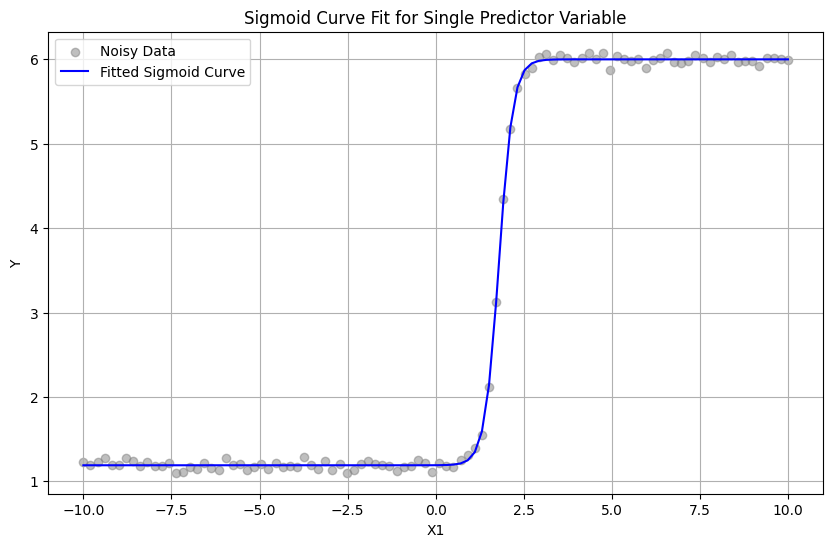

In [4]:
glm_single_variable = GeneralizedLogisticModel()

# Generate sample data
np.random.seed(42)
X1 = np.linspace(-10, 10, 100)
X0 = np.ones_like(X1)
X = np.column_stack([X0, X1])
# True sigmoid parameters
true_left_asymptote = 1.2
true_right_asymptote = 6.0
true_slope = [-9, 5]

# Generate Y data using the true sigmoid function
Y_true = sigmoid(
    X,
    true_left_asymptote,
    true_right_asymptote,
    np.array(true_slope))


# Add some noise to the Y values
noise = 0.05 * np.random.randn(len(X1))
Y_noisy = Y_true.ravel() + noise

glm_single_variable.model(Y_noisy, X)

glm_single_variable.fit(method="lm") # , max_nfev=10000

Y_fitted = glm_single_variable.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X1, Y_noisy, color="gray", alpha=0.5, label="Noisy Data")
plt.plot(X1, Y_fitted, color="blue", label="Fitted Sigmoid Curve")
plt.title("Sigmoid Curve Fit for Single Predictor Variable")
plt.xlabel("X1")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

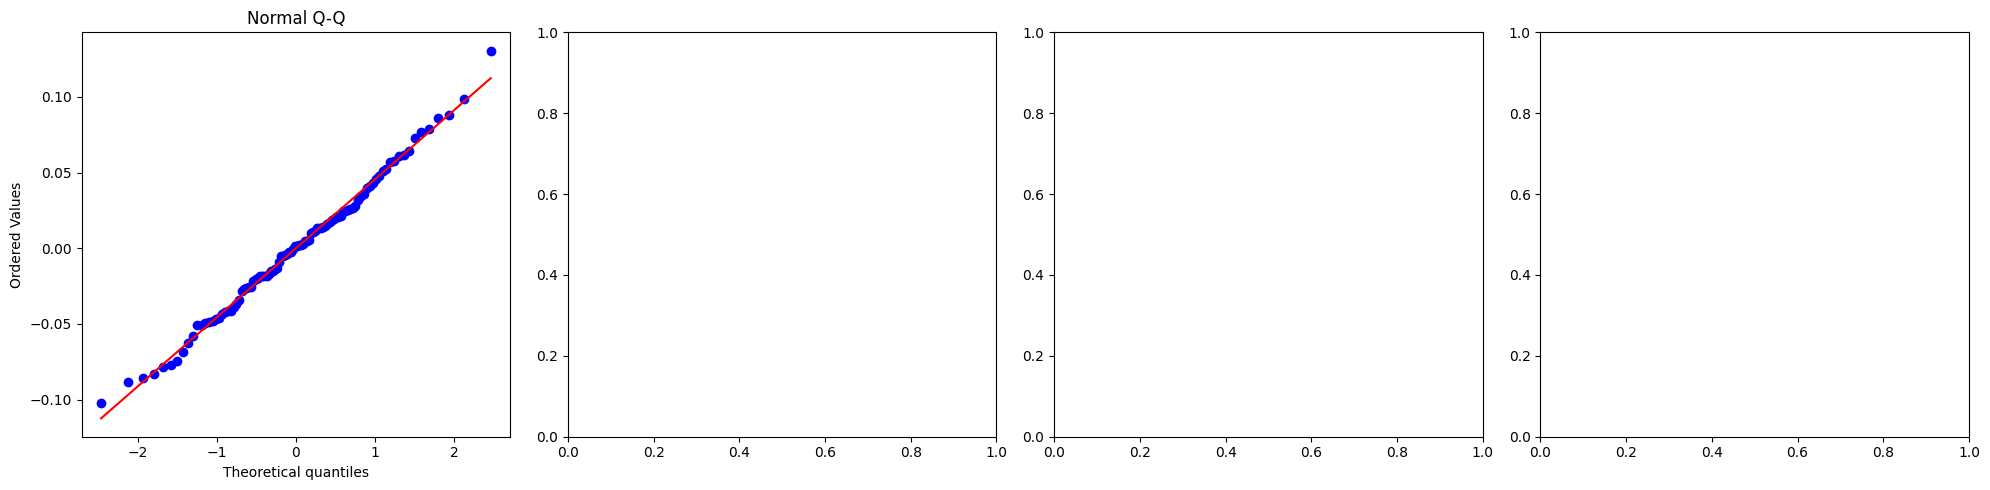


Generalized Logistic Model Summary

| Parameter       |   Estimate |
|:----------------|-----------:|
| left_asymptote  |     1.1904 |
| right_asymptote |     5.9996 |
| coef_0          |    -8.9032 |
| coef_1          |     4.9538 |

Model Diagnostics Comparison
| Metric                               |   Sigmoid Model |   Linear Model |
|:-------------------------------------|----------------:|---------------:|
| Variance Explained (R-squared)       |          0.9996 |         0.7537 |
| Akaike Information Criterion (AIC)   |       -329.001  |       315.751  |
| Bayesian Information Criterion (BIC) |       -318.58   |       320.962  |

Likelihood Ratio Test (LRT) vs Linear Model
|:-----------------------------|---------:|
| Linear Model Log-Likelihood  | -155.876 |
| Sigmoid Model Log-Likelihood |  168.5   |
| LRT Statistic                |  648.752 |
| p-value                      |    0     |

LRT Comparisons with Reduced Models
| Model                                |   Log-Likeli

In [5]:
glm_single_variable.plot()

glm_single_variable.summary()

### Multivariate Example

In [6]:
glm_two_variable = GeneralizedLogisticModel()

# Generate sample data
np.random.seed(42)
X1 = np.linspace(-10, 10, 100)
X2 = np.linspace(-10, 10, 100)
X0 = np.ones_like(X1)

# True sigmoid parameters
true_left_asymptote = 1.3
true_right_asymptote = 9.5
true_slope = np.array([-7, 1.6, 1.6])  # Slopes for both variables

# Stack X1 and X2 to form a design matrix with two variables
X_two_vars = np.column_stack([X0, X1, X2])

# Generate Y data using the true sigmoid function
Y_true = sigmoid(
    X_two_vars,
    true_left_asymptote,
    true_right_asymptote,
    true_slope
)

# Add some noise to the Y values
noise = 0.75 * np.random.randn(len(X1))
Y_noisy = Y_true.ravel() + noise

# Fit the model to the noisy data
glm_two_variable.model(Y_noisy, X_two_vars)

# note that bounds and other initial parameters can be passed to the fit method
# there is one additional method, dogbox, which is available
# from scipy.optimize.curve_fit
glm_two_variable.fit(method="trf", max_nfev=100000)

# Predict using the fitted model
Y_fitted = glm_two_variable.predict(X_two_vars)

# glm_two_variable.plot()

glm_two_variable.summary()


Generalized Logistic Model Summary

| Parameter       |   Estimate |
|:----------------|-----------:|
| left_asymptote  |     1.1573 |
| right_asymptote |     9.5234 |
| coef_0          |    -6.2911 |
| coef_1          |    -2.2532 |
| coef_2          |     5.1284 |

Model Diagnostics Comparison
| Metric                               |   Sigmoid Model |   Linear Model |
|:-------------------------------------|----------------:|---------------:|
| Variance Explained (R-squared)       |          0.9716 |         0.7273 |
| Akaike Information Criterion (AIC)   |        214.452  |       434.633  |
| Bayesian Information Criterion (BIC) |        227.478  |       439.844  |

Likelihood Ratio Test (LRT) vs Linear Model
|:-----------------------------|---------:|
| Linear Model Log-Likelihood  | -215.317 |
| Sigmoid Model Log-Likelihood | -102.226 |
| LRT Statistic                |  226.181 |
| p-value                      |    0     |

LRT Comparisons with Reduced Models
| Model             

In [ ]:
import plotly.graph_objs as go
import numpy as np

# Predict Y values for X1 and X2 using the fitted model (plot the line instead of surface)
Y_fitted_line = glm_two_variable.predict(X_two_vars)

# Create the 3D scatter plot for noisy data (X1, X2, Y_noisy)
scatter_data = go.Scatter3d(
    x=X1, y=X2, z=Y_noisy, 
    mode='markers',
    marker=dict(size=5, color='gray', opacity=0.7),
    name='Noisy Data'
)

# Create the 3D line plot for the fitted sigmoid model
line_data = go.Scatter3d(
    x=X1, y=X2, z=Y_fitted_line, 
    mode='lines',
    line=dict(color='blue', width=4),
    name='Fitted Sigmoid Line'
)

# Set up the layout for the plot
layout = go.Layout(
    title="Interactive 3D Sigmoid Line with Noisy Data",
    scene=dict(
        xaxis_title='X1(x)',
        yaxis_title='X2(y)',
        zaxis_title='Y(z)'
    ),
    autosize=True,
    width=900,
    height=700
)

# Create the figure
fig = go.Figure(data=[scatter_data, line_data], layout=layout)

# Show the plot
fig.show()


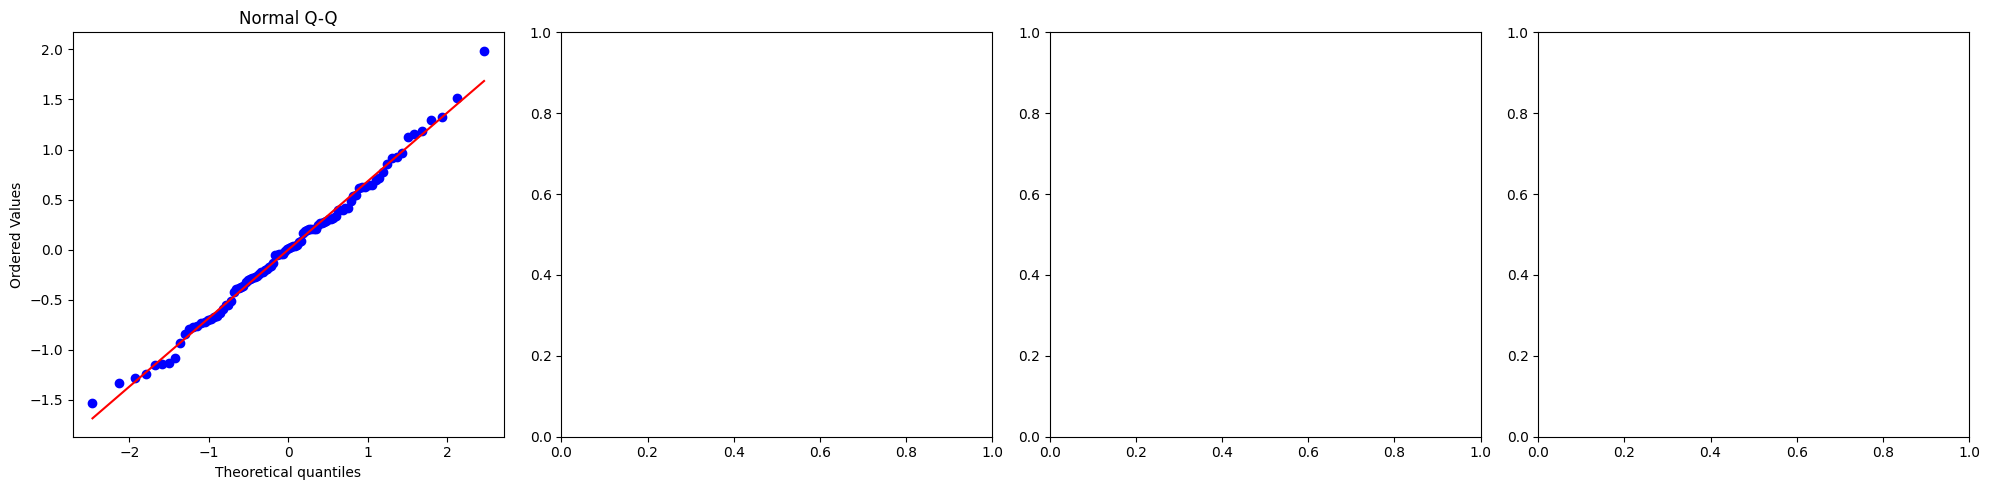

In [8]:
glm_two_variable.plot()

In [9]:
glm_two_variable.summary()


Generalized Logistic Model Summary

| Parameter       |   Estimate |
|:----------------|-----------:|
| left_asymptote  |     1.1573 |
| right_asymptote |     9.5234 |
| coef_0          |    -6.2911 |
| coef_1          |    -2.2532 |
| coef_2          |     5.1284 |

Model Diagnostics Comparison
| Metric                               |   Sigmoid Model |   Linear Model |
|:-------------------------------------|----------------:|---------------:|
| Variance Explained (R-squared)       |          0.9716 |         0.7273 |
| Akaike Information Criterion (AIC)   |        214.452  |       434.633  |
| Bayesian Information Criterion (BIC) |        227.478  |       439.844  |

Likelihood Ratio Test (LRT) vs Linear Model
|:-----------------------------|---------:|
| Linear Model Log-Likelihood  | -215.317 |
| Sigmoid Model Log-Likelihood | -102.226 |
| LRT Statistic                |  226.181 |
| p-value                      |    0     |

LRT Comparisons with Reduced Models
| Model             

## Fitting the Sigmoid model to real data


Generalized Logistic Model Summary

| Parameter       |   Estimate |
|:----------------|-----------:|
| left_asymptote  |     0.3136 |
| right_asymptote |     1.4538 |
| coef_0          |    -5.2551 |
| coef_1          |     0.6793 |
| coef_2          |     1.0907 |

Model Diagnostics Comparison
| Metric                               |   Sigmoid Model |   Linear Model |
|:-------------------------------------|----------------:|---------------:|
| Variance Explained (R-squared)       |          0.1155 |         0.1028 |
| Akaike Information Criterion (AIC)   |       1510.23   |      1594.22   |
| Bayesian Information Criterion (BIC) |       1543.85   |      1614.39   |

Likelihood Ratio Test (LRT) vs Linear Model
|:-----------------------------|----------:|
| Linear Model Log-Likelihood  | -794.11   |
| Sigmoid Model Log-Likelihood | -750.115  |
| LRT Statistic                |   87.9894 |
| p-value                      |    0      |

LRT Comparisons with Reduced Models
| Model        

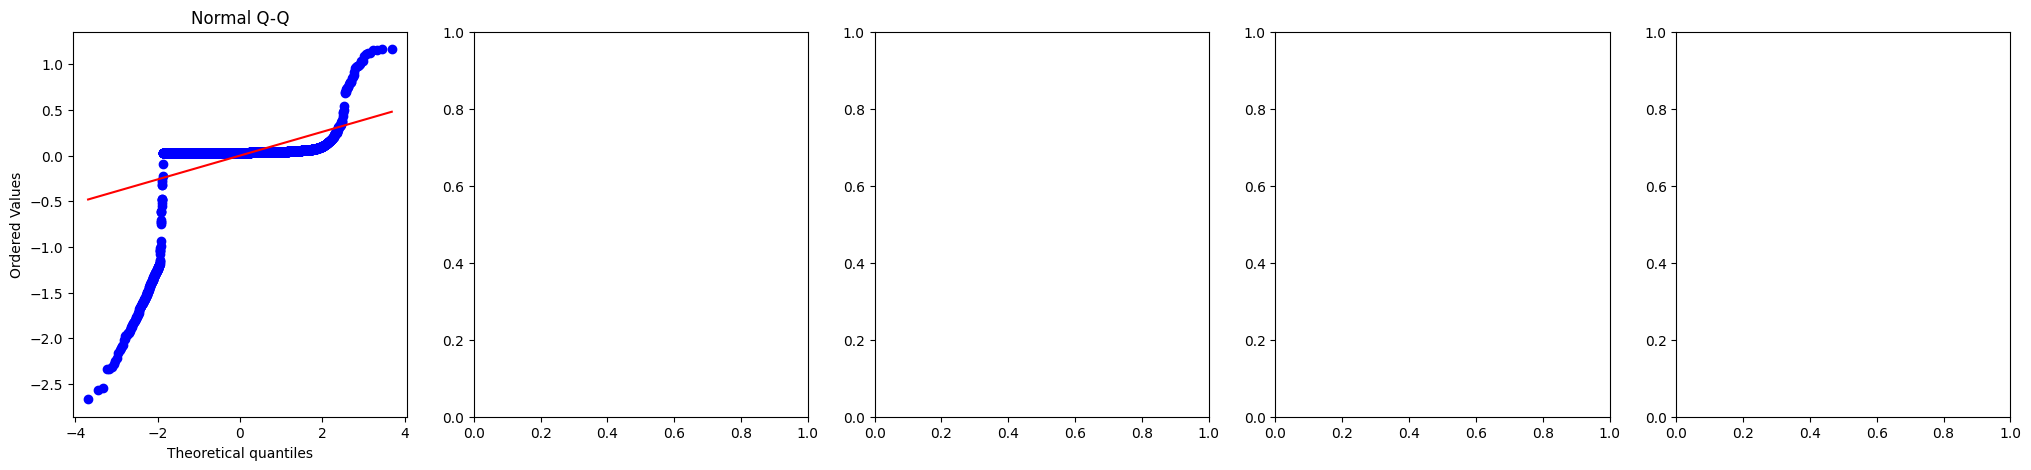

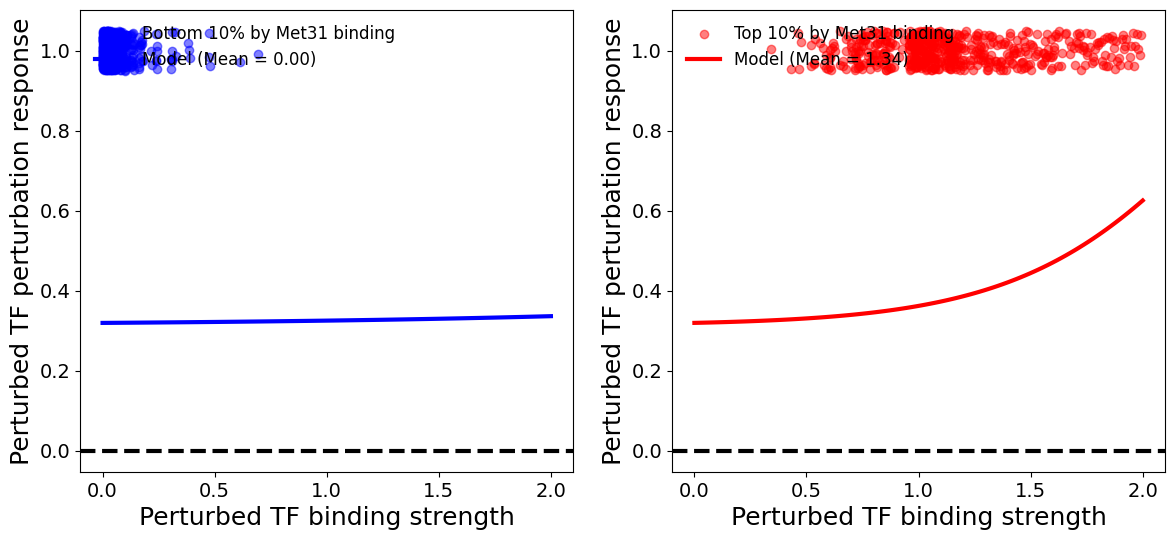

<Figure size 640x480 with 0 Axes>

In [10]:
# Note that for this to work in your environment, this path must point to a real file
met28_met31 = pd.read_csv("../../tmp/met28_met31.csv")
model_string = "met28_shifted_lrr ~ met28_shifted_lrb + met28_shifted_lrb:met31_shifted_lrb"
y_met28_met31, X_met28_met31_interaction = pt.dmatrices(model_string, data=met28_met31)

y_met28_met31 = np.asanyarray(y_met28_met31).ravel()
X_met28_met31_interaction = np.asarray(X_met28_met31_interaction)


met28_met31_model_interaction = GeneralizedLogisticModel()
met28_met31_model_interaction.model(y_met28_met31, X_met28_met31_interaction)
met28_met31_model_interaction.fit(method="lm")

met28_met31_model_interaction.summary()
met28_met31_model_interaction.plot(interactor_diagnostic=True)